# IVP Tests

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# %% Project bootstrap (root, imports, editable install)
from pathlib import Path
import sys, os, subprocess, importlib.util

def find_project_root(start: Path) -> Path:
    """Walk up until we see a project marker (pyproject.toml, .git, or defaults.yaml)."""
    p = start.resolve()
    markers = {"pyproject.toml", ".git", "defaults.yaml"}
    while p != p.parent:
        if any((p / m).exists() for m in markers):
            return p
        p = p.parent
    return start.resolve()

# works for both .ipynb (no __file__) and .py notebooks
_here = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
ROOT = find_project_root(_here)
os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

def ensure_editable_installed(pkg_name: str, pkg_dir: Path):
    """Install `-e .` iff the import isn't present or doesn't point to this repo."""
    spec = importlib.util.find_spec(pkg_name)
    if not spec or not getattr(spec, "origin", None):
        need_install = True
    else:
        # e.g. .../diffinst/__init__.py  → compare parent (package dir) to repo path
        pkg_path = Path(spec.origin).resolve().parent
        need_install = not pkg_path.samefile(pkg_dir.resolve())
    if need_install:
        print(f"Installing {pkg_name} in editable mode from {ROOT} ...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-e", str(ROOT)], check=True)
    else:
        print(f"{pkg_name} already installed from this repo.")

ensure_editable_installed("diffinst", ROOT / "diffinst")

# now imports are safe and point to this repo
from diffinst import Config
from diffinst.linear_ops import evp_solve_at_k

# handy paths
EXP_STABLE   = ROOT / "experiments" / "baseline.yaml"
EXP_UNSTABLE = ROOT / "experiments" / "unstable_baseline.yaml"
DEFAULTS     = ROOT / "defaults.yaml"
RUNS         = ROOT / "runs"; RUNS.mkdir(exist_ok=True)

print("project root:", ROOT)

diffinst already installed from this repo.
project root: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst


In [3]:
! python -m scripts.run_linear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/lin_k100 \
  --mode linear \
  --k 100 \
  --dt 1e-2 \
  --stop_time 5 \
  --save-stride 100 \
  --amp 1e-1 \
  --amp-physical \
  --amp-metric max

[linear] done: {'t_final': 5.0, 'steps': 501, 'Nx': 128, 'Lx': 0.12566370614359174}


In [4]:
RUN = Path("runs/lin_k100")  # <-- adjust if your run dir is different

# --- 1) Manifest + config
man = json.loads((RUN / "run.json").read_text())
Nx = int(man["Nx"]); Lx = float(man["Lx"])
cfg_path = man["config"]
cfg = Config.from_yaml(cfg_path)
Sigma0 = cfg.sig_0

# --- 2) Metrics (optional: for k_track + amp_S_k)
k_track = None
amp_track = []
t_metrics = []
mfile = RUN / "metrics.jsonl"
if mfile.exists():
    with mfile.open() as f:
        for line in f:
            row = json.loads(line)
            if "k_track" in row:
                if k_track is None:
                    k_track = float(row["k_track"])
                t_metrics.append(float(row["t"]))
                amp_track.append(float(row.get("amp_S_k", np.nan)))
amp_track = np.array(amp_track) if len(amp_track) else None
t_metrics = np.array(t_metrics) if len(t_metrics) else None

# --- 3) Load checkpoints and rebuild density field Σ(x,t)
chk_dir = RUN / "checkpoints"
chk_files = sorted(chk_dir.glob("chk_*.npz"))
if not chk_files:
    raise FileNotFoundError(f"No checkpoints in {chk_dir}")

# spatial grid
x = np.linspace(-0.5*Lx, 0.5*Lx, Nx, endpoint=False)

T = []                 # times
Sigma_snapshots = []   # Σ(x,t)
Smax = []              # max|Σ - Σ0| per snapshot (perturbation peak)

for fn in chk_files:
    with np.load(fn) as Z:
        t = float(Z["t"])
        k = Z["k"]               # angular k from rfftfreq; len Nk = Nx//2 + 1
        Xhat = Z["Xhat"]         # shape (Nk, 4): [S, vx, vy, uy]
        S_hat = Xhat[:, 0]       # complex spectrum of the density perturbation

    # reconstruct perturbation in real space (length Nx) via irfft
    s_x = np.fft.irfft(S_hat, n=Nx)              # real perturbation
    Sigma = Sigma0 + s_x                         # total surface density

    T.append(t)
    Sigma_snapshots.append(Sigma)
    Smax.append(np.max(np.abs(s_x)))

T = np.array(T)
Sigma_snapshots = np.array(Sigma_snapshots)      # shape (Nt, Nx)
Smax = np.array(Smax)

print(f"loaded {len(chk_files)} checkpoints; Nx={Nx}, Lx={Lx:.6g}, k_track={k_track}")

loaded 53 checkpoints; Nx=128, Lx=0.125664, k_track=100.0


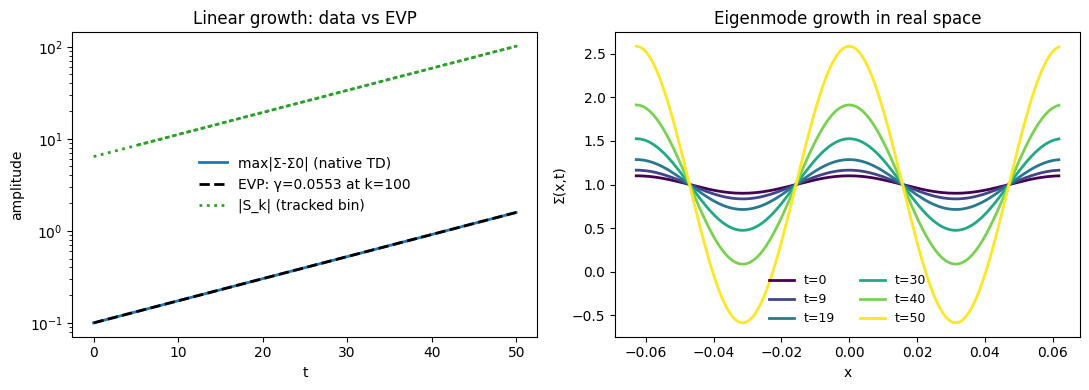

In [5]:
# --- (a) growth curve vs EVP prediction
fig, ax = plt.subplots(1, 2, figsize=(11,4))

# growth from max|s(x)|
ax[0].plot(T, np.maximum(Smax, 1e-20), lw=2, label="max|Σ-Σ0| (native TD)")
ax[0].set_yscale("log")
ax[0].set_xlabel("t")
ax[0].set_ylabel("amplitude")

# EVP prediction at k_track (fallback: use nearest bin to requested --k, if present)
if k_track is not None:
    w, V = evp_solve_at_k(cfg, k_track)
    gamma = w[0].real  # dominant growth rate
    # Match normalization to first snapshot
    a0 = Smax[0] if Smax[0] > 0 else (Smax[Smax>0][0] if np.any(Smax>0) else 1e-12)
    ax[0].plot(T, a0 * np.exp(gamma*(T - T[0])), "k--", lw=2,
               label=f"EVP: γ={gamma:.3g} at k={k_track:.3g}")
else:
    # optional fallback: estimate k_track from metrics abscent — skip EVP overlay
    pass

# If we have spectral amplitude tracking from metrics, show it too
if (t_metrics is not None) and (amp_track is not None) and len(amp_track):
    ax[0].plot(t_metrics, np.maximum(amp_track, 1e-20), "C2:", lw=2, label="|S_k| (tracked bin)")

ax[0].legend(frameon=False)
ax[0].set_title("Linear growth: data vs EVP")

# --- (b) spatial snapshots of Σ(x,t)
# choose ~6 evenly spaced snapshots
nsamp = 6
idxs = np.linspace(0, len(T)-1, nsamp, dtype=int)
cmap = plt.cm.viridis
tmin, tmax = float(T[0]), float(T[-1])

for j, i in enumerate(idxs):
    c = cmap(j/(nsamp-1) if nsamp>1 else 0.0)
    ax[1].plot(x, Sigma_snapshots[i], color=c, lw=2, label=f"t={T[i]:.3g}")

ax[1].set_xlabel("x")
ax[1].set_ylabel("Σ(x,t)")
ax[1].set_title("Eigenmode growth in real space")
ax[1].legend(ncol=2, frameon=False, fontsize=9)

plt.tight_layout()
plt.show()

In [6]:
# %% Helpers for loading/analysis (linear + nonlinear)
import json
import numpy as np
from pathlib import Path

def load_linear_run(run_dir: Path):
    man = json.loads((run_dir / "run.json").read_text())
    Nx = int(man["Nx"]); Lx = float(man["Lx"])
    mfile = run_dir / "metrics.jsonl"
    k_track, t_metrics, amp_track = None, [], []
    if mfile.exists():
        with mfile.open() as f:
            for line in f:
                row = json.loads(line)
                if "k_track" in row and "amp_S_k" in row:
                    if k_track is None:
                        k_track = float(row["k_track"])
                    t_metrics.append(float(row["t"]))
                    amp_track.append(float(row.get("amp_S_k", np.nan)))
    t_metrics = np.asarray(t_metrics) if len(t_metrics) else None
    amp_track = np.asarray(amp_track) if len(amp_track) else None

    chk_dir = run_dir / "checkpoints"
    files = sorted(chk_dir.glob("chk_*.npz"))
    if not files:
        raise FileNotFoundError(f"No checkpoints in {chk_dir}")
    Z0 = np.load(files[0])
    k = Z0["k"]  # linear run stores k and Xhat
    Z0.close()
    return Nx, Lx, np.asarray(files), k, t_metrics, amp_track, k_track

def load_linear_Sigma_series(files, Nx, Sigma0):
    T, Smax = [], []
    for fn in files:
        with np.load(fn) as Z:
            t = float(Z["t"])
            Xhat = Z["Xhat"]; S_hat = Xhat[:, 0]
        s_x = np.fft.irfft(S_hat, n=Nx)
        Sigma = Sigma0 + s_x
        T.append(t)
        Smax.append(np.max(np.abs(s_x)))
    return np.asarray(T), np.asarray(Smax)

def load_nonlinear_run(run_dir: Path):
    man = json.loads((run_dir / "run.json").read_text())
    Nx = int(man["Nx"]); Lx = float(man["Lx"])
    chk_dir = run_dir / "checkpoints"
    files = sorted(chk_dir.glob("chk_*.npz"))
    if not files:
        raise FileNotFoundError(f"No checkpoints in {chk_dir}")
    return Nx, Lx, np.asarray(files)

def load_nonlinear_Sigma_series(files):
    T, Sigma_list = [], []
    for fn in files:
        with np.load(fn) as Z:
            t = float(Z["t"]); Sigma = Z["Sigma"]
        T.append(t); Sigma_list.append(Sigma)
    return np.asarray(T), np.asarray(Sigma_list)

def mode_amp(signal, k_index):
    return abs(np.fft.rfft(signal)[k_index])

def nearest_k_index(Lx, Nx, k_phys):
    # rfftfreq gives wavenumbers 2π * rfftfreq; here we want physical k (rad/unit)
    ks = 2.0 * np.pi * np.fft.rfftfreq(Nx, d=Lx / Nx)
    return int(np.argmin(abs(ks - k_phys)))

In [7]:
# %% Build a single eigenmode IC and save to .npz for both solvers
from diffinst.linear_ops import evp_solve_at_k

IC_OUT = RUNS / "ic_k100_eigen.npz"
k_phys = 100.0  # match the linear run param exactly
amp_phys = 1e-6

cfg_ic  = Config.from_yaml(EXP_UNSTABLE, DEFAULTS)
Nx_ic   = int(cfg_ic.Nx)
Lx_ic   = float(cfg_ic.Lx)
x = np.linspace(-0.5*Lx_ic, 0.5*Lx_ic, Nx_ic, endpoint=False)
S0 = float(getattr(cfg_ic, "S0", getattr(cfg_ic, "sig_0", 1.0)))

w, V = evp_solve_at_k(cfg_ic, k_phys)
v = V[:, 0]
expikx = np.exp(1j * k_phys * (x - x.min()))
S_raw  = (v[0] * expikx).real
vx_raw = (v[1] * expikx).real
vy_raw = (v[2] * expikx).real
uy_raw = (v[3] * expikx).real

scale = amp_phys / max(np.max(np.abs(S_raw)), 1e-30)
Sigma0 = S0 + scale * S_raw
vx0    = scale * vx_raw
vy0    = scale * vy_raw
uy0    = scale * uy_raw

np.savez_compressed(IC_OUT, x=x, Sigma=Sigma0, vx=vx0, vy=vy0, uy=uy0)
print("IC written:", IC_OUT)

IC written: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/ic_k100_eigen.npz


In [35]:
# %% Run linear TD from the same IC
! python -m scripts.run_linear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/lin_from_ic \
  --mode linear \
  --dt 1e-2 \
  --stop_time 10 \
  --save-stride 200 \
  --init-from runs/ic_k100_eigen.npz

[linear] done: {'t_final': 10.0, 'steps': 1001, 'Nx': 128, 'Lx': 0.12566370614359174}


In [36]:
# %% Run nonlinear TD from the same IC (no seeding logic used)
! python -m scripts.run_nonlinear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/nl_from_ic \
  --mode nonlinear \
  --dt 1e-2 \
  --stop_time 10 \
  --save-stride 200 \
  --init-from runs/ic_k100_eigen.npz

[nonlinear] done: {'t_final': 10.0, 'steps': 1001, 'Nx': 128, 'Lx': 0.12566370614359174}


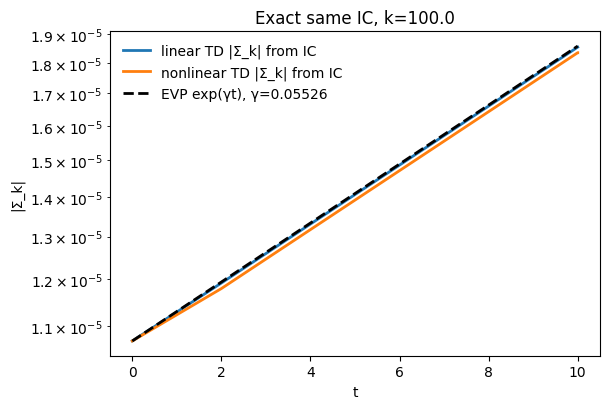

In [37]:
# %% Compare amplitudes WITHOUT normalization (identical ICs)
RUN_L_EQ = RUNS / "lin_from_ic"
RUN_N_EQ = RUNS / "nl_from_ic"

# linear load
NxL, LxL, filesL, k_arr, t_metL, a_metL, _ = load_linear_run(RUN_L_EQ)
cfgL = Config.from_yaml(json.loads((RUN_L_EQ / "run.json").read_text())["config"])
S0L  = cfgL.sig_0
TL, SmaxL = load_linear_Sigma_series(filesL, NxL, S0L)

# nonlinear load
NxN, LxN, filesN = load_nonlinear_run(RUN_N_EQ)
TN, SigmaN = load_nonlinear_Sigma_series(filesN)

# pick the exact k index from IC
k_idx = nearest_k_index(LxN, NxN, k_phys)
A_lin = []
for fn in filesL:
    with np.load(fn) as Z:
        S_hat = Z["Xhat"][:,0]
        s_x = np.fft.irfft(S_hat, n=NxL)
        A_lin.append(abs(np.fft.rfft(s_x)[k_idx]))
A_lin = np.array(A_lin)

A_nl = np.array([abs(np.fft.rfft(S - S.mean())[k_idx]) for S in SigmaN])

fig, ax = plt.subplots(1,1, figsize=(6.2,4.2))
ax.plot(TL, A_lin, lw=2, label="linear TD |Σ_k| from IC")
ax.plot(TN, A_nl,  lw=2, label="nonlinear TD |Σ_k| from IC")

# EVP reference from *same* γ
w_ref, _ = evp_solve_at_k(cfgL, k_phys); gamma_ref = w_ref[0].real
A0 = A_lin[0]
ax.plot(TL, A0 * np.exp(gamma_ref*(TL - TL[0])), "k--", lw=2, label=f"EVP exp(γt), γ={gamma_ref:.4g}")

ax.set_yscale("log"); ax.set_xlabel("t"); ax.set_ylabel("|Σ_k|")
ax.legend(frameon=False); ax.set_title(f"Exact same IC, k={k_phys}")
plt.tight_layout(); plt.show()

In [12]:
# %% Recover linear operator from RHS at k via small complex sinusoid
import numpy as np
from diffinst.linear_ops import L_of_k
from diffinst.nonlinear_terms import rhs
from diffinst.operators import PSOperators

def rhs_symbol_from_nonlinear(cfg, k_phys, Nx=None, Lx=None, eps_amp=1e-8):
    """
    Build the 4x4 symbol M_nl(k) so that d/dt [S, vx, vy, uy]^T ≈ M_nl(k) [S, vx, vy, uy]^T
    by probing the nonlinear RHS with small complex plane waves at wavenumber k_phys.
    """
    # domain
    Nx = int(Nx if Nx is not None else cfg.Nx)
    Lx = float(Lx if Lx is not None else cfg.Lx)
    x  = np.linspace(-0.5*Lx, 0.5*Lx, Nx, endpoint=False)
    ops = PSOperators(nx=Nx, Lx=Lx, dealias=False)

    # base state (uniform)
    S0   = float(getattr(cfg, "S0", getattr(cfg, "sig_0", 1.0)))
    vx0  = np.zeros(Nx); vy0 = np.zeros(Nx); uy0 = np.zeros(Nx)
    base = {"Sigma": S0*np.ones(Nx), "vx": vx0, "vy": vy0, "uy": uy0}

    # params dict used by nonlinear_terms
    params = dict(
        D0=float(getattr(cfg, "D0", getattr(cfg, "D_0", 0.0))),
        beta_diff=float(getattr(cfg, "beta_diff", 0.0)),
        nu0=float(getattr(cfg, "nu0", getattr(cfg, "nu_0", 0.0))),
        beta_visc=float(getattr(cfg, "beta_visc", 0.0)),
        S0=S0,
        Omega=float(getattr(cfg, "Omega", 0.0)),
        q=float(getattr(cfg, "q", 1.5)),
        ts=float(getattr(cfg, "ts", 1.0)),
        eps=float(getattr(cfg, "eps", getattr(cfg, "epsilon", 0.0))),
        nu_g=float(getattr(cfg, "nu_g", 0.0)),
    )

    # complex plane wave
    eikx = np.exp(1j * k_phys * (x - x.min()))
    M = np.zeros((4,4), dtype=complex)

    # probe columns: add one variable = eps * Re(e^{ikx}), measure response, project back onto e^{ikx}
    cols = [
        ("Sigma",), ("vx",), ("vy",), ("uy",)
    ]
    for j, (name,) in enumerate(cols):
        pert = {k: np.zeros(Nx, dtype=float) for k in base.keys()}
        # use real part; projection will pick out the k component (imag parts are handled in complex fit)
        pert[name] = eps_amp * eikx.real

        st = {k: (base[k] + pert[k]) for k in base.keys()}
        dr = rhs(st, params, ops)  # dictionary with time derivatives

        # project each derivative back onto e^{ikx} to get the k-mode coefficient
        for i, key in enumerate(["Sigma","vx","vy","uy"]):
            # inner product with cos and sin to reconstruct complex amp at k
            y = dr[key]
            # compute complex coefficient of e^{ikx}: use FFT at the matching k-bin
            # find k index that matches k_phys on this grid
            ks = 2.0*np.pi*np.fft.rfftfreq(Nx, d=Lx/Nx)
            ik = int(np.argmin(np.abs(ks - k_phys)))
            Yk = np.fft.rfft(y)[ik]
            Xk = np.fft.rfft(pert[name])[ik]
            M[i, j] = (Yk / (Xk + 0j))  # derivative per unit amplitude at that k

    return M

# Quick compare helper
def compare_symbols(cfg, k_phys, Nx=None, Lx=None):
    M_nl = rhs_symbol_from_nonlinear(cfg, k_phys, Nx=Nx, Lx=Lx)
    M_ev = L_of_k(cfg, float(k_phys))
    err = np.abs(M_nl - M_ev)
    rel = err / (np.maximum(1e-14, np.abs(M_ev)))
    return M_nl, M_ev, err, rel

# Example: run at your k_phys with the same domain as the runs
k_test = float(k_phys)
M_nl, M_ev, err, rel = compare_symbols(cfgL, k_test, Nx=NxN, Lx=LxN)
print("max abs err:", np.max(err))
print("max rel err:", np.max(rel))
print("per-entry rel err:\n", np.array_str(rel, precision=3, suppress_small=True))

max abs err: 200.0
max rel err: 2.0000000010975305
per-entry rel err:
 [[0. 2. 0. 0.]
 [2. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 2. 1.]]


In [13]:
np.set_printoptions(precision=5, suppress=True)
print("M_ev(k):\n", M_ev.real, "+ i*", M_ev.imag)
print("M_nl(k):\n", M_nl.real, "+ i*", M_nl.imag)
print("rel err:\n", rel)

M_ev(k):
 [[  0.        0.        0.        0.     ]
 [  0.      -10.13333   2.        0.     ]
 [ -0.       -0.5     -10.1      10.     ]
 [  0.        0.       10.      -20.     ]] + i* [[  0.      100.        0.        0.     ]
 [ -0.00487   0.        0.        0.     ]
 [ -0.00225   0.        0.        0.     ]
 [  0.        0.        0.        0.     ]]
M_nl(k):
 [[  0.       -0.        0.        0.     ]
 [  0.      -10.13333   2.        0.     ]
 [  0.       -0.5     -10.1      10.     ]
 [  0.        0.      -10.       -0.     ]] + i* [[  -0.      -100.        -0.        -0.     ]
 [   0.00487    0.         0.        -0.     ]
 [   0.00225    0.         0.        -0.     ]
 [  -0.        -0.         0.        -0.     ]]
rel err:
 [[0. 2. 0. 0.]
 [2. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 2. 1.]]
